In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# this dataset will crash the kernel if loaded fully, so we need to load a sampled version of it
data = pd.read_csv('../../../../data/NF-UNSW-NB15-v3/data/NF-UNSW-NB15-v3.csv')
# drop data with NaN or inf values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()
data.reset_index(drop=True, inplace=True)

In [3]:
# Sample 10% of the data, stratified by 'label' to validate the algorithm. keep category distribution
sampled_data, _ = train_test_split(
    data,
    test_size=0.9,  # Keep 10%
    stratify=data['Attack'],
    random_state=42
)

# Use sampled_data for the rest of the notebook
data = sampled_data

In [4]:
data

,FLOW_START_MILLISECONDS,FLOW_END_MILLISECONDS,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
993654,1424220880939,1424220880940,59.166.0.3,44546,149.171.126.1,53,17,5.0,130,2,...,0,0,0,0,0,0,0,0,0,Benign
1635678,1421947475324,1421947475347,59.166.0.0,24494,149.171.126.5,22331,6,36.0,2438,38,...,0,8,0,1,0,8,0,1,0,Benign
1629760,1421947178599,1421947178634,59.166.0.0,40903,149.171.126.4,8286,6,36.0,2974,48,...,0,5,0,1,0,5,0,1,0,Benign
749302,1424239699421,1424239699450,59.166.0.7,16074,149.171.126.0,35440,6,36.0,3926,66,...,0,4,0,0,0,4,0,0,0,Benign
1504105,1421942155382,1421942155678,59.166.0.4,12049,149.171.126.9,21,6,37.0,1251,23,...,0,97,10,20,0,106,11,21,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634105,1424248142223,1424248142299,59.166.0.6,63528,149.171.126.9,13716,6,36.0,3614,60,...,0,6,1,1,0,5,1,1,0,Benign
1302527,1421933787211,1421933787419,59.166.0.2,50035,149.171.126.8,22,6,92.0,3728,32,...,0,56,6,13,0,56,8,14,0,Benign
990500,1424227430308,1424227430878,59.166.0.8,26796,149.171.126.4,21,6,37.0,1817,33,...,0,197,17,38,0,275,18,47,0,Benign
623927,1424254886026,1424254886044,59.166.0.1,24211,149.171.126.8,6881,6,37.0,1540,16,...,0,5,0,1,0,7,0,1,0,Benign


In [5]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [6]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [7]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [8]:
data.drop(columns=['FLOW_START_MILLISECONDS','FLOW_END_MILLISECONDS','L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [9]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Index: 224293 entries, 993654 to 2007259
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IPV4_SRC_ADDR                224293 non-null  object 
 1   IPV4_DST_ADDR                224293 non-null  object 
 2   PROTOCOL                     224293 non-null  int64  
 3   L7_PROTO                     224293 non-null  float64
 4   IN_BYTES                     224293 non-null  int64  
 5   IN_PKTS                      224293 non-null  int64  
 6   OUT_BYTES                    224293 non-null  int64  
 7   OUT_PKTS                     224293 non-null  int64  
 8   TCP_FLAGS                    224293 non-null  int64  
 9   CLIENT_TCP_FLAGS             224293 non-null  int64  
 10  SERVER_TCP_FLAGS             224293 non-null  int64  
 11  FLOW_DURATION_MILLISECONDS   224293 non-null  int64  
 12  DURATION_IN                  224293 non-null  int64  
 13

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,Label,Attack
993654,172.22.208.210:44546,149.171.126.1:53,17,5.0,130,2,162,2,0,0,...,0,0,0,0,0,0,0,0,0,Benign
1635678,172.30.59.241:24494,149.171.126.5:22331,6,36.0,2438,38,19502,40,27,27,...,0,8,0,1,0,8,0,1,0,Benign
1629760,172.28.173.211:40903,149.171.126.4:8286,6,36.0,2974,48,31920,50,27,27,...,0,5,0,1,0,5,0,1,0,Benign
749302,172.18.164.30:16074,149.171.126.0:35440,6,36.0,3926,66,54818,68,27,27,...,0,4,0,0,0,4,0,0,0,Benign
1504105,172.29.82.209:12049,149.171.126.9:21,6,37.0,1251,23,1752,25,24,24,...,0,97,10,20,0,106,11,21,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634105,172.17.74.111:63528,149.171.126.9:13716,6,36.0,3614,60,45044,62,27,27,...,0,6,1,1,0,5,1,1,0,Benign
1302527,172.21.168.220:50035,149.171.126.8:22,6,92.0,3728,32,5474,24,27,27,...,0,56,6,13,0,56,8,14,0,Benign
990500,172.25.204.57:26796,149.171.126.4:21,6,37.0,1817,33,2512,35,24,24,...,0,197,17,38,0,275,18,47,0,Benign
623927,172.23.157.232:24211,149.171.126.8:6881,6,37.0,1540,16,1644,18,27,27,...,0,5,0,1,0,7,0,1,0,Benign


In [10]:
data.drop(columns=['Label'],inplace = True)

In [11]:
data.rename(columns={"Attack": "label"},inplace = True)

In [12]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [13]:
label = data.label

In [14]:
data.drop(columns=['label'],inplace = True)

In [15]:
scaler = StandardScaler()

In [16]:
data =  pd.concat([data, label], axis=1)

In [17]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label
993654,172.22.208.210:44546,149.171.126.1:53,17,5.0,130,2,162,2,0,0,...,0,0,0,0,0,0,0,0,0,2
1635678,172.30.59.241:24494,149.171.126.5:22331,6,36.0,2438,38,19502,40,27,27,...,0,0,8,0,1,0,8,0,1,2
1629760,172.28.173.211:40903,149.171.126.4:8286,6,36.0,2974,48,31920,50,27,27,...,0,0,5,0,1,0,5,0,1,2
749302,172.18.164.30:16074,149.171.126.0:35440,6,36.0,3926,66,54818,68,27,27,...,0,0,4,0,0,0,4,0,0,2
1504105,172.29.82.209:12049,149.171.126.9:21,6,37.0,1251,23,1752,25,24,24,...,229,0,97,10,20,0,106,11,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634105,172.17.74.111:63528,149.171.126.9:13716,6,36.0,3614,60,45044,62,27,27,...,0,0,6,1,1,0,5,1,1,2
1302527,172.21.168.220:50035,149.171.126.8:22,6,92.0,3728,32,5474,24,27,27,...,0,0,56,6,13,0,56,8,14,2
990500,172.25.204.57:26796,149.171.126.4:21,6,37.0,1817,33,2512,35,24,24,...,229,0,197,17,38,0,275,18,47,2
623927,172.23.157.232:24211,149.171.126.8:6881,6,37.0,1540,16,1644,18,27,27,...,0,0,5,0,1,0,7,0,1,2


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [19]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

In [20]:
# normalize all columns except the first four and the label column
cols_to_norm = list(set(list(X_train.iloc[:, 4:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [21]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [22]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label,h
574069,172.26.16.187:13127,149.171.126.4:5190,2.131942,2.272871,-0.058911,-0.208868,-0.222740,-0.286498,-0.159502,0.623689,...,-0.022231,-0.212598,-0.081591,-0.203372,-0.005287,-0.224443,-0.150531,-0.214694,2,"[-0.253963073174466, -0.47652989321356465, -0...."
182756,172.23.36.154:5006,149.171.126.8:21,2.131942,2.000000,-0.077690,-0.387341,-0.229047,-0.312331,-0.163196,0.335319,...,-0.022231,-0.270593,-0.097246,-0.267984,-0.005287,-0.282408,-0.235779,-0.314123,2,"[-0.27241734961820435, -0.47652989321356465, -..."
90032,172.20.128.34:37747,149.171.126.4:2040,2.131942,2.000000,-0.000425,0.559938,0.228967,0.281839,-0.159502,0.623689,...,-0.022231,-0.266968,-0.097246,-0.267984,-0.005287,-0.286360,-0.249987,-0.321771,2,"[0.28121094369394606, 2.0315502359829902, -0.2..."
815163,172.24.21.225:18511,149.171.126.1:36006,2.131942,2.000000,-0.036580,0.065705,-0.088309,-0.045385,-0.159502,0.623689,...,-0.022231,-0.253677,-0.085504,-0.244489,-0.005287,-0.270552,-0.207363,-0.291178,2,"[-0.0694203087370825, 0.38832532375076473, -0...."
1467899,172.16.205.94:39805,149.171.126.2:6881,2.131942,2.000000,0.166676,2.674154,3.298391,3.364632,-0.159502,0.623689,...,-0.022231,0.402391,-0.085504,-0.062401,-0.005287,0.444786,-0.235779,-0.130563,2,"[3.307712280467035, 2.809919931250887, 0.21543..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585862,172.23.48.27:28346,149.171.126.6:21,2.131942,2.000000,-0.086653,-0.497170,-0.232630,-0.381220,-0.163196,0.335319,...,-0.022231,-0.246428,-0.081591,-0.226868,-0.005287,-0.262647,-0.122115,-0.252936,2,"[-0.30932590250568104, -1.0819285450885952, -0..."
1384422,172.29.53.226:44765,149.171.126.4:80,2.131942,2.287661,-0.056822,-0.346155,-0.168359,-0.252053,-0.159502,0.623689,...,-0.022231,0.931595,0.262820,1.406047,-0.005287,1.023117,0.588282,1.467934,2,"[-0.23550879673072764, -0.3900443715171317, 0...."
2176178,172.30.58.207:14212,149.171.126.2:143,2.131942,2.127719,0.061554,1.163999,-0.139506,0.677952,-0.159502,0.623689,...,-0.022231,-0.274217,-0.097246,-0.273858,-0.005287,-0.292947,-0.249987,-0.329419,2,"[0.26275666725020774, 1.9450647142865576, -0.2..."
1656227,172.26.99.126:3884,149.171.126.8:21,2.131942,2.435557,-0.067247,-0.250054,-0.224376,-0.226220,-0.163196,0.335319,...,-0.022231,-0.196891,-0.073763,-0.191625,-0.005287,-0.196778,-0.164739,-0.214694,2,"[-0.2170545202869893, -0.21707332812426586, -0..."


In [23]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [24]:
G = G.to_directed()


In [25]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [26]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [27]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [28]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [29]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [30]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [31]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [32]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [33]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, num_classes)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [34]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(G.edata['label'].cpu().numpy()),
                                                 y=G.edata['label'].cpu().numpy())

In [35]:
#class_weights = th.FloatTensor(class_weights).cuda()  - if you have a nvidia GPU
class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [36]:
# uncomment if you have a NVIDIA GPU
# G = G.to('cuda:0')
G.device

device(type='cpu')

In [37]:
G.ndata['h'].device


device(type='cpu')

In [38]:
G.edata['h'].device


device(type='cpu')

In [39]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']
num_classes = len(np.unique(G.edata['label'].cpu().numpy()))

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2, num_classes) #.cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,50): # original 8000, maybe too much and will cause out of memory error
    pred = model(G, node_features,edge_features) #.cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


In [40]:
X_test = encoder.transform(X_test)

In [41]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [42]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,...,FTP_COMMAND_RET_CODE,SRC_TO_DST_IAT_MIN,SRC_TO_DST_IAT_MAX,SRC_TO_DST_IAT_AVG,SRC_TO_DST_IAT_STDDEV,DST_TO_SRC_IAT_MIN,DST_TO_SRC_IAT_MAX,DST_TO_SRC_IAT_AVG,DST_TO_SRC_IAT_STDDEV,label
260222,172.28.208.120:22143,149.171.126.6:53,2.002328,2.001450,-0.084052,-0.483442,-0.232727,-0.389832,-0.211171,-1.971635,...,-0.466513,-0.022231,-0.275425,-0.097246,-0.273858,-0.005287,-0.294264,-0.249987,-0.329419,2
1760818,172.30.250.53:8552,149.171.126.7:45157,2.131942,2.083278,-0.012236,-0.236325,-0.217379,-0.234831,-0.159502,0.623689,...,-0.466513,-0.022231,-0.181184,-0.081591,-0.174003,-0.005287,-0.192826,-0.193155,-0.199398,2
264259,172.19.202.65:17890,149.171.126.4:22,2.131942,2.000608,0.186766,0.834511,-0.123476,0.454062,-0.159502,0.623689,...,-0.466513,-0.022231,-0.230721,-0.097246,-0.250363,-0.005287,-0.244204,-0.249987,-0.298826,2
2134217,172.21.134.80:26129,149.171.126.6:21,2.131942,2.435557,-0.086653,-0.497170,-0.232630,-0.381220,-0.163196,0.335319,...,3.375201,-0.022231,-0.152186,-0.030712,-0.068275,-0.005287,-0.158574,0.162043,-0.038783,2
166468,172.28.108.22:56621,149.171.126.4:26975,2.131942,2.000000,-0.022452,0.257907,0.025491,0.092393,-0.159502,0.623689,...,-0.466513,-0.022231,-0.270593,-0.097246,-0.273858,-0.005287,-0.290312,-0.249987,-0.329419,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924211,172.25.70.199:45349,149.171.126.8:53,2.002328,2.001450,-0.084355,-0.483442,-0.232830,-0.389832,-0.211171,-1.971635,...,-0.466513,-0.022231,-0.275425,-0.097246,-0.273858,-0.005287,-0.294264,-0.249987,-0.329419,2
1496036,172.23.210.3:33692,149.171.126.0:21,2.131942,2.000000,-0.058474,-0.140225,-0.220626,-0.157330,-0.163196,0.335319,...,0.984286,-0.022231,0.229614,0.094529,0.360512,-0.005287,0.432930,0.517242,0.550137,2
1094819,172.21.97.192:48657,149.171.126.4:21,2.131942,2.000000,-0.058474,-0.140225,-0.220626,-0.157330,-0.163196,0.335319,...,0.984286,-0.022231,-0.273009,-0.097246,-0.273858,-0.005287,-0.291630,-0.249987,-0.329419,2
477315,172.27.177.19:24686,149.171.126.9:53,2.002328,2.001450,-0.084052,-0.483442,-0.232727,-0.389832,-0.211171,-1.971635,...,-0.466513,-0.022231,-0.275425,-0.097246,-0.273858,-0.005287,-0.294264,-0.249987,-0.329419,2


In [43]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [44]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [45]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [46]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [47]:
# G_test = G_test.to('cuda:0')


In [48]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test) #.cuda()
elapsed = timeit.default_timer() - start_time

In [49]:
print(str(elapsed) + ' seconds')


0.42999619999318384 seconds


In [50]:
test_pred = test_pred.argmax(1)


In [51]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [52]:
actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [ ]:
# from sklearn.metrics import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (c:\Users\riko.lusa\src\phd-i4sec\.venv\Lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
""" import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show() """

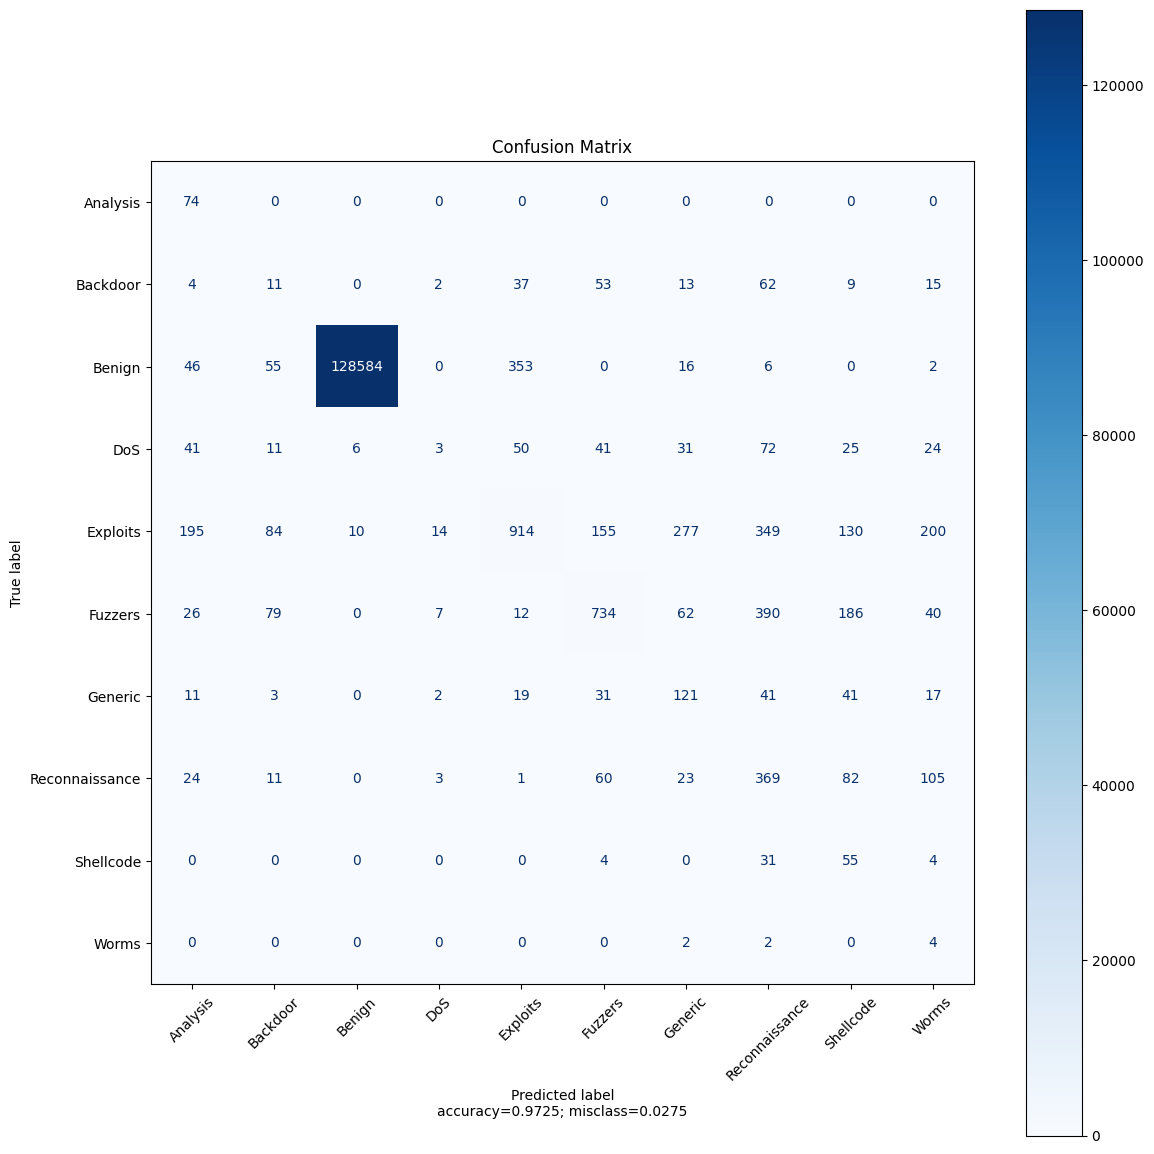

In [ ]:
""" from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix") """
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(actual, test_pred)
labels = np.unique(actual)
accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Use a perceptually uniform colormap and set vmin for better low-value visibility
disp.plot(ax=ax, cmap=plt.get_cmap('viridis'), colorbar=True, vmin=0)
plt.title("Confusion Matrix")
plt.xlabel(f'Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}')
plt.ylabel('True label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()